In [1]:
import optimization_SPDC as opt
import optimization_SPDC_gaussain_pump as gauss_opt
import get_initialization_cond as init 
import save_data as save
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy
import jax.scipy.optimize as jax_opt

np.random.seed(0)
key = jax.random.PRNGKey(0)

# Set general hyperparameters

In [2]:
Np = 0.02
# higher N and wf+wi makes less unstable pump... need to see if N or wf+wi influences more
N = 801
wi = -10
wf = 10
x = np.linspace(wi, wf, N)
w = np.linspace(2*wi, 2*wf, 2*N)
# get the group velocities for all modes
vp = 0.1
l = 1
# For an unstable pump, just change amplitude to 0.2 and width to 0.2 at N = 1
hermite_init_params = [1, 0.05, 0.5, jnp.pi/5]
cst_init_params = [0.1]
alpha, G, H = init.get_constants(vp, l, wi, wf, Np, N = N)
# get the initialization seeds
initial_value_gauss = jnp.array([0.5, 1., 2*jnp.pi/7])
arbitrary_seed_hermite_order_1 = init.get_initialization_array(hermite_init_params, vp, l, wi, wf, Np, method='hermite', N = N)
phi = 2*np.pi*np.random.random()

# Experiment with $\left <N\right> = 1$

## Set $\left<N\right>$

In [3]:
y_N = 1

## Optimization with BFGS

In [20]:
optimal_arbitrary_pump = (jax_opt.minimize(opt.get_loss, arbitrary_seed_hermite_order_1,args=(N, alpha, G, H, l, y_N), method = "BFGS")).x
optimal_arbitrary_complex_pump = opt.get_complex_array(optimal_arbitrary_pump)
optimal_gaussian_theta = (jax_opt.minimize(gauss_opt.get_loss,initial_value_gauss, args = (w, alpha, G, H, l, y_N), method="BFGS")).x
optimal_gaussian_pump = gauss_opt.get_gaussian_pump(optimal_gaussian_theta, w)

## Plotting results

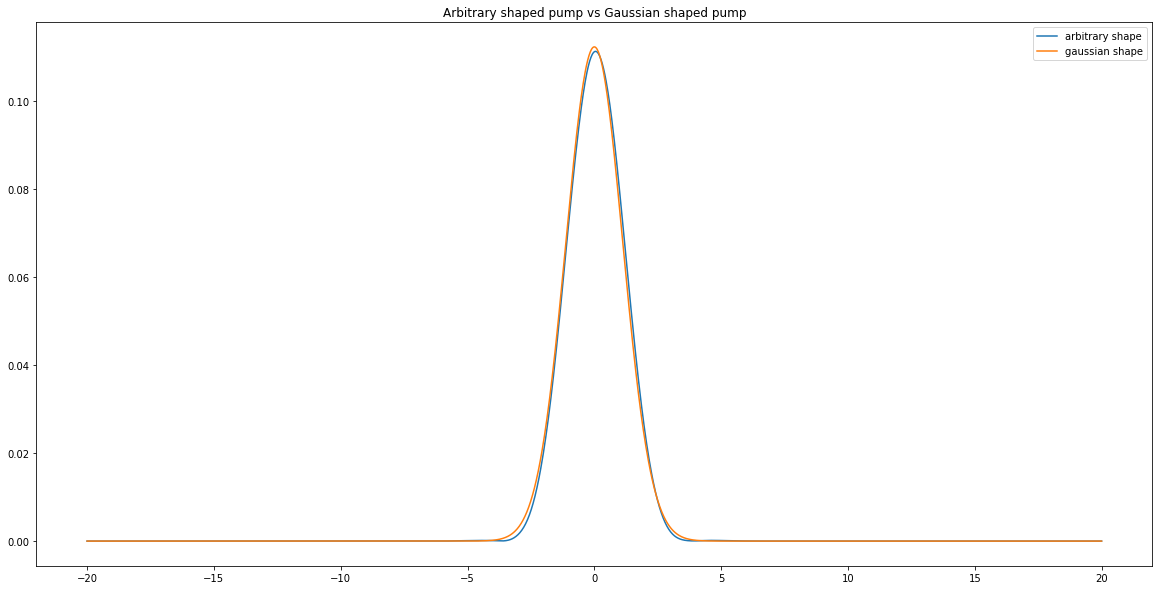

In [21]:
plt.figure(figsize=(20,10))
plt.title("Arbitrary shaped pump vs Gaussian shaped pump")
plt.plot(w, np.abs(optimal_arbitrary_complex_pump)/np.linalg.norm(optimal_arbitrary_complex_pump), label = "arbitrary shape")
plt.plot(w, np.abs(optimal_gaussian_pump)/np.linalg.norm(optimal_gaussian_pump), label = "gaussian shape")
plt.legend()

# Experimentation with many N values 

## Set all possible values of $\left<N\right>$

In [3]:
y_Ns = jnp.array([0.1, 0.5, 1, 2, 3, 4, 5])

## Optimization with BFGS

In [18]:
K_values_arbitrary = []
N_values_arbitrary = []
arbitrary_optimized_params = []
arbitrary_optimized_complex_params = []
K_values_gauss = []
N_values_gauss = []
gaussian_optimized_params = []
gaussian_optimized_complex_pump = []
for i in range(len(y_Ns)):
    optimized_arbitrary_pump = (jax_opt.minimize(opt.get_loss, arbitrary_seed_hermite_order_1, args = (N, alpha, G, H, l, y_Ns[i]), method="BFGS")).x
    arbitrary_optimized_params.append(optimized_arbitrary_pump)
    arbitrary_optimized_complex_params.append(opt.get_complex_array(optimized_arbitrary_pump))
    N_values_arbitrary.append(opt.get_observables(optimized_arbitrary_pump, N, alpha, G, H, l)[0])
    K_values_arbitrary.append(opt.get_observables(optimized_arbitrary_pump, N, alpha, G, H, l)[1])
    optimized_gaussian_params = (jax_opt.minimize(gauss_opt.get_loss, initial_value_gauss, args=(w, alpha, G, H, l, y_Ns[i]), method= "BFGS")).x
    gaussian_optimized_params.append(optimized_gaussian_params)
    gaussian_optimized_complex_pump.append(optimized_gaussian_params[0]*jnp.exp(-(w*optimized_gaussian_params[1])**2)*jnp.exp(1j*optimized_gaussian_params[2]))
    K_values_gauss.append(gauss_opt.get_observable(optimized_gaussian_params, w, alpha, G, H, l)[1])
    N_values_gauss.append(gauss_opt.get_observable(optimized_gaussian_params, w, alpha, G, H, l)[0])
    print("Finished " + str(y_Ns[i]) + " number of pairs created")

Finished 0.1 number of pairs created
Finished 0.5 number of pairs created
Finished 1.0 number of pairs created
Finished 2.0 number of pairs created
Finished 3.0 number of pairs created
Finished 4.0 number of pairs created
Finished 5.0 number of pairs created


## Plotting results

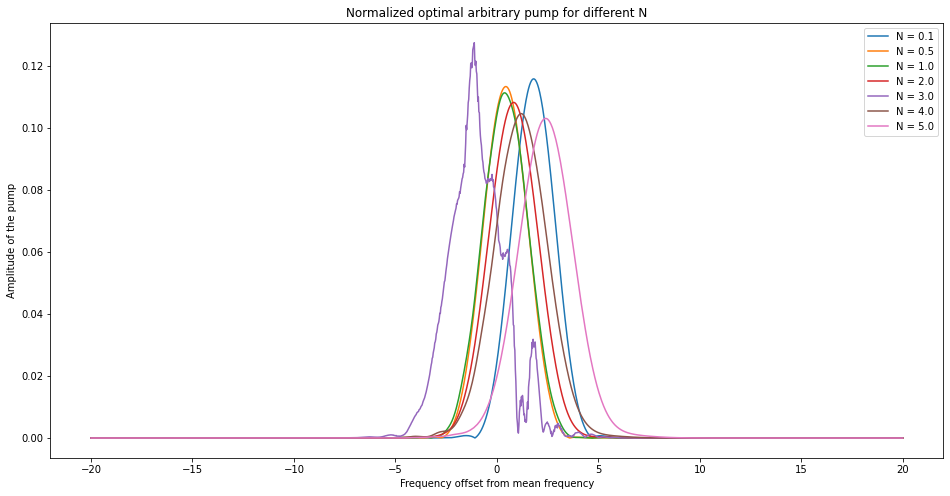

In [19]:
plt.figure(figsize = (16,8))
plt.title("Normalized optimal arbitrary pump for different N")
plt.xlabel("Frequency offset from mean frequency")
plt.ylabel("Amplitude of the pump")
for i in range(len(arbitrary_optimized_params)):
    plt.plot(w, jnp.abs(arbitrary_optimized_complex_params[i]/jnp.linalg.norm(arbitrary_optimized_complex_params[i])), label = "N = "+str(y_Ns[i]))
plt.legend()

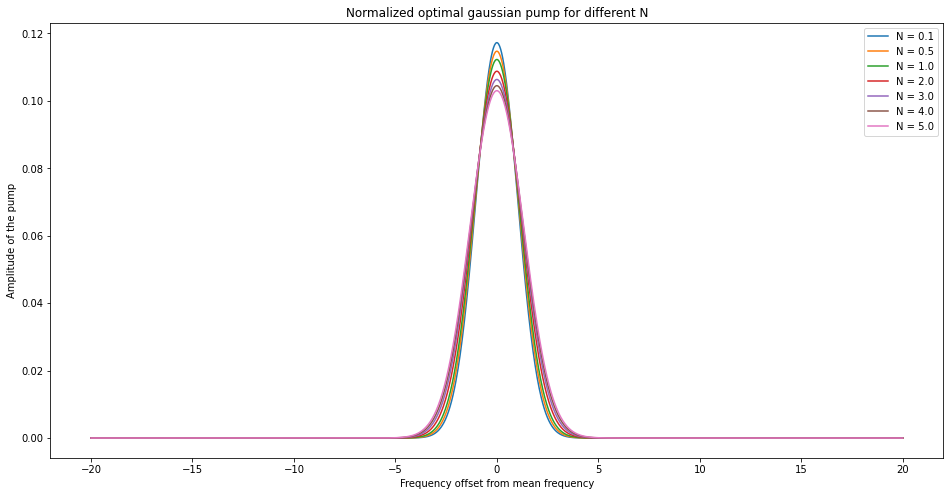

In [20]:
plt.figure(figsize = (16,8))
plt.title("Normalized optimal gaussian pump for different N")
plt.xlabel("Frequency offset from mean frequency")
plt.ylabel("Amplitude of the pump")
for i in range(len(arbitrary_optimized_params)):
    plt.plot(w, jnp.abs(gaussian_optimized_complex_pump[i]/jnp.linalg.norm(gaussian_optimized_complex_pump[i])), label = "N = "+str(y_Ns[i]))
plt.legend()

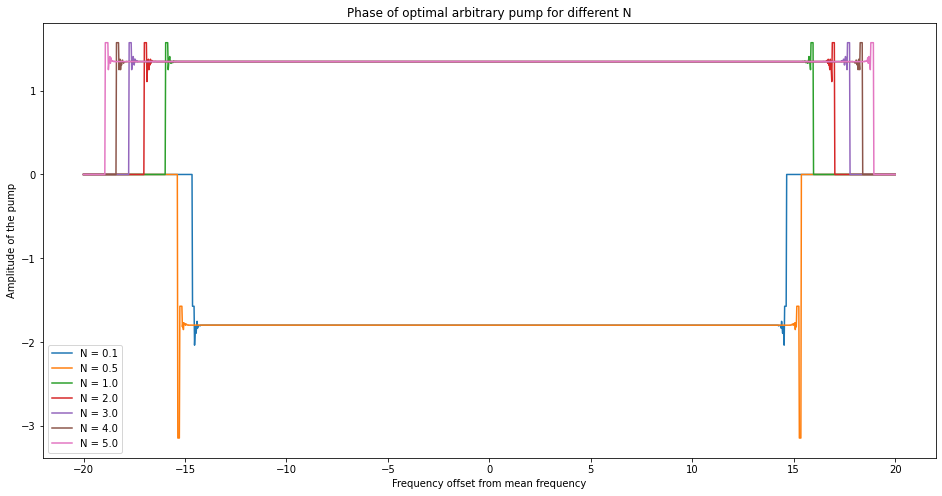

In [7]:
plt.figure(figsize = (16,8))
plt.title("Phase of optimal arbitrary pump for different N")
plt.xlabel("Frequency offset from mean frequency")
plt.ylabel("Amplitude of the pump")
for i in range(len(arbitrary_optimized_params)):
    plt.plot(w, jnp.angle(gaussian_optimized_complex_pump[i]/jnp.linalg.norm(gaussian_optimized_complex_pump[i])), label = "N = "+str(y_Ns[i]))
plt.legend()

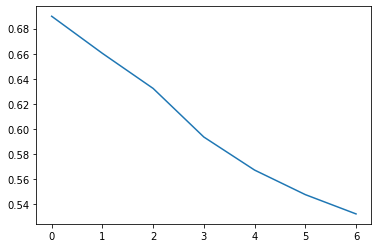

In [28]:
plt.plot(np.array(gaussian_optimized_params).T[1])

In [25]:
K_values_gauss, K_values_arbitrary

([DeviceArray(1.2017771, dtype=float32),
  DeviceArray(1.169891, dtype=float32),
  DeviceArray(1.1422957, dtype=float32),
  DeviceArray(1.1083034, dtype=float32),
  DeviceArray(1.0880771, dtype=float32),
  DeviceArray(1.0745721, dtype=float32),
  DeviceArray(1.064865, dtype=float32)],
 [DeviceArray(1.1986483, dtype=float32),
  DeviceArray(1.1691366, dtype=float32),
  DeviceArray(1.1420541, dtype=float32),
  DeviceArray(1.1079186, dtype=float32),
  DeviceArray(1.1463771, dtype=float32),
  DeviceArray(1.074201, dtype=float32),
  DeviceArray(1.0638047, dtype=float32)])

## Save results and plots

In [32]:
save.save_data(N, wi, wf, Np, vp, l , y_Ns, arbitrary_optimized_params, "gauss_hermite_first_order", arbitrary_seed_hermite_order_1, 1, False)

In [31]:
y_Ns

DeviceArray([0.1, 0.5, 1. , 2. , 3. , 4. , 5. ], dtype=float32)

# Example of unstable pump

In [4]:
unstable_init_hermite_params = [1, 1, 1, jnp.pi/5]
initial_unstable_arbitrary_seed = init.get_initialization_array(unstable_init_hermite_params, vp, l, wi, wf, Np, method = "hermite", N = N)

In [5]:
unstable_opt_arbitrary_pump = (jax_opt.minimize(opt.get_loss, initial_unstable_arbitrary_seed, args = (N, alpha, G, H, l, y_N), method="BFGS")).x

In [6]:
unstabl_opt_arbitrary_complex_pump = opt.get_complex_array(unstable_opt_arbitrary_pump)

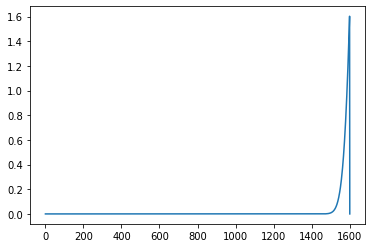

In [7]:
plt.plot(np.abs(unstabl_opt_arbitrary_complex_pump))